In [1]:
import numpy as np
np.set_printoptions(precision=16)
import pickle

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from qkeras.utils import model_save_quantized_weights

from tf_data_pipeline.data import WaveToWaveData
from qkeras_version.qkeras_model import create_dilated_model, masked_mse

from fxpmath_version.fxpmath_model import FxpModel

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

2023-10-12 13:21:15.722844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## train qkeras model

In [3]:
from fxpmath_version.util import FxpUtil

fxp = FxpUtil()
fxp.single_width(-1.0), fxp.bits(fxp.single_width(-1.0))

(fxp-s16/12(-1.0), '1111.000000000000')

In [3]:
class Opts(object):
    learning_rate = 1e-3
    num_train_egs = 20000
    num_validate_egs = 100
    num_test_egs = 100
    epochs = 5
    
opts = Opts()


In [4]:
IN_OUT_D = 4
NUM_LAYERS = 3
# WIP filter size; final will be 8
FILTER_SIZE = 4

# note: kernel size and implied dilation rate always assumed 4

RECEPTIVE_FIELD_SIZE = 4**NUM_LAYERS
TEST_SEQ_LEN = RECEPTIVE_FIELD_SIZE
TRAIN_SEQ_LEN = RECEPTIVE_FIELD_SIZE * 5
print("RECEPTIVE_FIELD_SIZE", RECEPTIVE_FIELD_SIZE)
print("TRAIN_SEQ_LEN", TRAIN_SEQ_LEN)
print("TEST_SEQ_LEN", TEST_SEQ_LEN)

RECEPTIVE_FIELD_SIZE 64
TRAIN_SEQ_LEN 320
TEST_SEQ_LEN 64


In [5]:
# make tf datasets

# recall WaveToWaveData
# x -> (tri,0,0,0)
# y -> (tri,square,zigzag,0)

data = WaveToWaveData()

train_ds = data.tf_dataset_for_split('train', TRAIN_SEQ_LEN, opts.num_train_egs)
validate_ds = data.tf_dataset_for_split('validate', TRAIN_SEQ_LEN, opts.num_validate_egs)

In [5]:
# make model
train_model = create_dilated_model(TRAIN_SEQ_LEN,
        in_out_d=IN_OUT_D, num_layers=NUM_LAYERS, filter_size=FILTER_SIZE,
        all_outputs=False)
print(train_model.summary())

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 4)]          0         
                                                                 
 qconv_0 (QConv1D)           (None, 320, 4)            68        
                                                                 
 qrelu_0 (QActivation)       (None, 320, 4)            0         
                                                                 
 qconv_1 (QConv1D)           (None, 320, 4)            68        
                                                                 
 qrelu_1 (QActivation)       (None, 320, 4)            0         
                                                          

In [6]:
# compile loss that only considers column 1 of output ( i.e. square wave )
train_model.compile(Adam(opts.learning_rate),
                    loss=masked_mse(RECEPTIVE_FIELD_SIZE, filter_column_idx=1))

In [7]:
train_model.fit(train_ds,
                validation_data=validate_ds,
                epochs=20)

Epoch 1/20
157/157 [==============================] - 6s 12ms/step - loss: 0.2873 - val_loss: 0.1079
Epoch 2/20
157/157 [==============================] - 2s 8ms/step - loss: 0.1016 - val_loss: 0.0904
Epoch 3/20
157/157 [==============================] - 1s 7ms/step - loss: 0.0855 - val_loss: 0.0744
Epoch 4/20
157/157 [==============================] - 2s 7ms/step - loss: 0.0695 - val_loss: 0.0626
Epoch 5/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0597 - val_loss: 0.0552
Epoch 6/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0533 - val_loss: 0.0504
Epoch 7/20
157/157 [==============================] - 1s 7ms/step - loss: 0.0484 - val_loss: 0.0463
Epoch 8/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0444 - val_loss: 0.0426
Epoch 9/20
157/157 [==============================] - 2s 9ms/step - loss: 0.0412 - val_loss: 0.0399
Epoch 10/20
157/157 [==============================] - 2s 7ms/step - loss: 0.0386 - val_loss: 0.037

In [11]:
weights = model_save_quantized_weights(train_model)
from qkeras.utils import model_save_quantized_weights
with open('qkeras_weights.pkl', 'wb') as f:
    pickle.dump(model_save_quantized_weights(train_model),
                f, protocol=pickle.HIGHEST_PROTOCOL)

... quantizing model
... quantizing model


In [3]:
with open('qkeras_weights.pkl', 'rb') as f:
    weights = pickle.load(f)

In [4]:
weights

{'qconv_0': {'weights': [array([[[-0.1743164 , -0.18017578,  0.09228516,  0.578125  ],
           [ 0.11962891, -0.4140625 ,  0.19580078, -0.2529297 ],
           [ 0.3095703 , -0.00537109,  0.5385742 ,  0.1274414 ],
           [-0.20507812,  0.00195312, -0.13623047, -0.6899414 ]],
   
          [[-0.57177734, -0.37451172,  0.45751953, -0.7055664 ],
           [ 0.1015625 , -0.55908203, -0.30371094,  0.03320312],
           [ 0.13134766, -0.08642578, -0.48046875,  0.45654297],
           [ 0.5678711 ,  0.19335938, -0.09619141,  0.04980469]],
   
          [[-0.00244141,  0.19580078,  0.6621094 , -0.30371094],
           [-0.01953125, -0.3725586 , -0.45214844,  0.4482422 ],
           [-0.10009766, -0.24853516, -0.12353516,  0.43847656],
           [ 0.        , -0.06005859, -0.25683594, -0.16259766]],
   
          [[-0.89404297,  1.0566406 ,  0.7602539 , -0.62353516],
           [-0.70947266, -0.25732422,  0.5776367 , -0.54052734],
           [ 0.37646484,  0.16210938,  0.15283203,  0

## load weights into fxp model

In [3]:
# make model
inference_model = create_dilated_model(TEST_SEQ_LEN,
        in_out_d=IN_OUT_D, num_layers=NUM_LAYERS, filter_size=FILTER_SIZE,
        all_outputs=False)
inference_model.set_weights(train_model.get_weights())
print(inference_model.summary())


NameError: name 'create_dilated_model' is not defined

## run fxp_model from weights files

see `python3 -m fxpmath_version.run_fxpmath_model`

In [16]:
with open("/tmp/test_x.hex", "w") as f:
    for i in range(len(x)):
        next_x = x[i].numpy()[0]
        fp_x = fxp_model.fxp.single_width(next_x)
        print(i, next_x, fp_x, fp_x.hex(), file=f)
        

In [27]:
eval('0xFFFD')

65533

In [10]:
0.25+0.125

0.375

In [ ]:

# a0=1, a1=a2=a3=0

# 
# veri [00000000.000011001100000000000000,  11111111.011001110000000000000000,  00000000.101100001100000000000000,  111111111.10000110100000000000000]
# fxp  [00000000.000011001100000000000000', 11111111.011001110000000000000000', 00000000.101100001100000000000000', '11111111.110000110100000000000000']
# after bias add...
# veri [00000000.011100010110000000000000,  11111111.010100010010000000000000, 00000000.001100000110000000000000, 11111111.001111011010000000000000]
# fxp  [00000000.011100010110000000000000', 11111111.010100010010000000000000, 00000000.001100000110000000000000, 11111111.001111011010000000000000']
# LGTM !

# a0=a1=1, a2=a3=0

# after bias add
# veri [00000000.101011000000000000000000, 11111110.011111011000000000000000, 11111111.110001000010000000000000, 11111111.000100110010000000000000]
# fxp  [00000000.101011000000000000000000, 11111110.011111011000000000000000, 11111111.110001000010000000000000, 11111111.000100110010000000000000']
# LGTM !

# a0=a1=a2=a3 = 1

# after bias add
# veri  [11111111.010100110110000000000000, 11111111.100111111000000000000000, 00000001.011001010100000000000000, 11111110.010110010100000000000000]
# fxp   [11111111.010100110110000000000000, 11111111.100111111000000000000000, 00000001.011001010100000000000000, 11111110.010110010100000000000000']
# LGTM

# a0=a1=a2=a3 = -1
# veri  [00000001.011101011110000000000000, 00000000.001101001100000000000000, 11111101.100110100000000000000000, 00000000.100110111000000000000000]
# fxp   [00000001.011101011110000000000000, 00000000.001101001100000000000000, 11111101.100110100000000000000000, 00000000.100110111000000000000000']
# LGTM

#     dut.a0.value = [
#        0x0400,   # 0000.010000000000 0.25
#        0xFDFC,   # 1111.110111111100 -0.1259765625
#        0x0506,   # 0000.010100000110 0.31396484375
#        0xF000    # 1111.000000000000 -1.0
# a0=a1=a2=a3

# veri [11111111.111001111110011101011100, 11111111.011100010110011101111100, 00000000.001100100110110101000100, 00000000.111001100001010110000000]
# fxp  [11111111.111001111110011101011100, 11111111.011100010110011101111100, 00000000.001100100110110101000100, 00000000.111001100001010110000000']

## plot values from verilog version

```
cat sverilog_version/tests/network/net.out \
 | grep ^OUT\ 1 \
 | cut -b26-41 \
 | python3 single_width_bin_to_decimal.py \
 > y_pred.sverilog.txt
```

/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

<Axes: xlabel='n', ylabel='y_pred'>

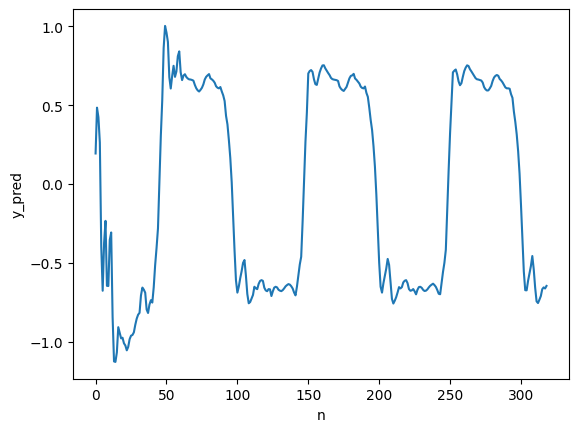

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_sverilog = open('y_pred.sverilog.txt').readlines()
y_pred_sverilog = list(map(float, y_pred_sverilog))

df = pd.DataFrame()
df['y_pred'] = y_pred_sverilog
df['n'] = range(len(y_pred_sverilog))

sns.lineplot(df, x='n', y='y_pred')

double check.. what should be the triangle wave input

```
cat sverilog_version/tests/network/net.out | grep ^next_x | uniq | cut -d' ' -f2 > test_x.txt
```

In [ ]:
test_x_sverilog = open('test_x.txt').readlines()
test_x_sverilog = list(map(float, test_x_sverilog))

df = pd.DataFrame()
df['test_x'] = test_x_sverilog
df['n'] = range(len(test_x_sverilog))

sns.lineplot(df, x='n', y='test_x')

## receptive field for 192kHz

given the 192kHz resampled data, how much does a receptive field cover?


In [19]:
#fname = '/data2/cached_dilated_causal_convolutions/2d_embed/96kHz/tri_squ_zigzag.ssv'
#fname = '/data2/cached_dilated_causal_convolutions/2d_embed/192kHz_resampled/tri_squ_zigzag.ssv'
fname = '/data2/cached_dilated_causal_convolutions/2d_embed/192kHz_resampled/tri_squ_zigzag.ssv'

df = pd.read_csv(fname, sep=' ', names=['tri', 'squ', 'zigzag'])
df['n'] = range(len(df))

df.head()

,tri,squ,zigzag,n
0,0.117282,-0.699751,-0.385114,0
1,0.112893,-0.699677,-0.382844,1
2,0.108505,-0.699603,-0.380574,2
3,0.104471,-0.699363,-0.378252,3
4,0.100437,-0.699124,-0.375929,4


/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

<Axes: xlabel='n', ylabel='value'>

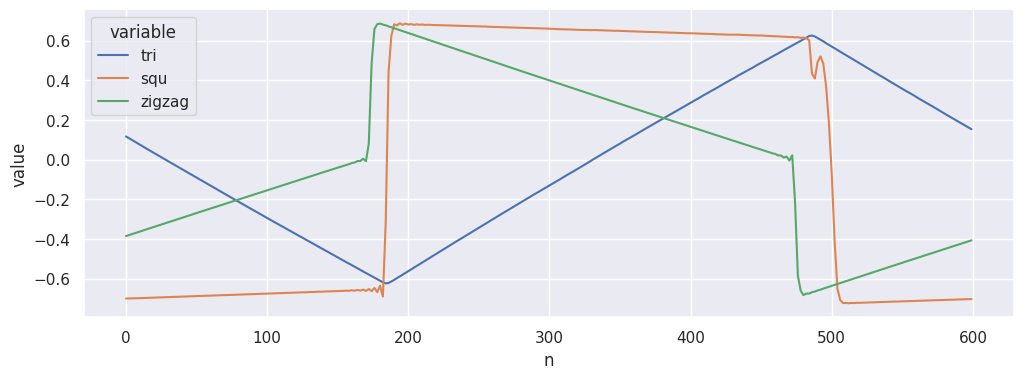

In [25]:
first_512_df = df[:600]
wide_df = first_512_df.melt(id_vars='n', value_vars=['tri', 'squ', 'zigzag'])

sns.set(rc={"figure.figsize": (12, 4)})
sns.lineplot(wide_df, x='n', y='value', hue='variable')